In [3]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [6]:
images_path = "Dataset.zip"
with zipfile.ZipFile(images_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [7]:
print("Number of horse images:",len(os.listdir('/content/dataset/Dataset/Bad_Image/')))
print("Number of humanimages:", len(os.listdir('/content/dataset/Dataset/Good_Image/')))

Number of bad images: 224
Number of good images: 117


In [ ]:
try:
    os.mkdir('/content/dataset/Dataset/bad-vs-good')
    os.mkdir('/content/dataset/Dataset/bad-vs-good/training')
    os.mkdir('/content/dataset/Dataset/bad-vs-good/testing')
    os.mkdir('/content/dataset/Dataset/bad-vs-good/training/bad')
    os.mkdir('/content/dataset/Dataset/bad-vs-good/training/good')
    os.mkdir('/content/dataset/Dataset/bad-vs-good/testing/bad')
    os.mkdir('/content/dataset/Dataset/bad-vs-good/testing/good')
except OSError:
    pass

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


bad_SOURCE_DIR = '/content/dataset/Dataset/Bad_Image/'
TRAINING_bad_DIR = "/content/dataset/Dataset/bad-vs-good/training/bad/"
TESTING_bad_DIR = "/content/dataset/Dataset/bad-vs-good/testing/bad/"
good_SOURCE_DIR = '/content/dataset/Dataset/Good_Image/'
TRAINING_good_DIR = "/content/dataset/Dataset/bad-vs-good/training/good/"
TESTING_good_DIR = "/content/dataset/Dataset/bad-vs-good/testing/good/"

split_size = .9
split_data(bad_SOURCE_DIR, TRAINING_bad_DIR, TESTING_bad_DIR, split_size)
split_data(good_SOURCE_DIR, TRAINING_good_DIR, TESTING_good_DIR, split_size)


In [ ]:
print("Number of training bad images", len(os.listdir('/content/dataset/Dataset/bad-vs-good/training/bad/')))
print("Number of testing bad images", len(os.listdir('/content/dataset/Dataset/bad-vs-good/testing/bad/')))
print("Number of training good images", len(os.listdir('/content/dataset/Dataset/bad-vs-good/training/good/')))
print("Number of testing good images", len(os.listdir('/content/dataset/Dataset/bad-vs-good/testing/good/')))


Number of training bad images 201
Number of testing bad images 23
Number of training good images 105
Number of testing good images 12


In [ ]:
TRAINING_DIR = "/content/dataset/Dataset/bad-vs-good/training/"
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/content/dataset/Dataset/bad-vs-good/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 306 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output



last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)


In [ ]:

# compile the model
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=16,
            verbose=1)

Epoch 1/16
Epoch 2/16
Epoch 3/16
Epoch 4/16
Epoch 5/16
Epoch 6/16
Epoch 7/16
Epoch 8/16
Epoch 9/16
Epoch 10/16
Epoch 11/16
Epoch 12/16
Epoch 13/16
Epoch 14/16
Epoch 15/16
Epoch 16/16


<Figure size 432x288 with 0 Axes>

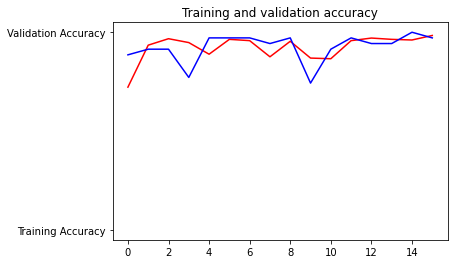

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()



In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a good")
  else:
    print(fn + " is a bad")

Saving 07012022_casselton_barley_P1_200ft_transparent_mosaic_group1_411.jpg to 07012022_casselton_barley_P1_200ft_transparent_mosaic_group1_411.jpg
1/1 [==============================] - 0s 24ms/step
[[0.]]
[0.]
07012022_casselton_barley_P1_200ft_transparent_mosaic_group1_411.jpg is a bad
